In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

file_path = 'data.csv'

data = pd.read_csv(file_path)

data["sex"].replace(['male', 'female'], [0, 1], inplace=True)
data["smoker"].replace(['no', 'yes'], [0, 1],  inplace=True)
# data_model = data.drop("region", axis=1)
# print(data_model)

region_dummies = pd.get_dummies(data['region'], prefix='is', prefix_sep='_')


# Concaténer les colonnes binaires avec le DataFrame original
data = pd.concat([data, region_dummies], axis=1)
data = data.drop(['region'], axis=1)

# Vérification des informations manquantes et des doublons
missing_data = data.isnull().sum()
duplicates = data.duplicated().sum()
data = data.drop_duplicates()




# Afficher le DataFrame avec les nouvelles colonnes binaires
print(data.head())


   age  sex     bmi  children  smoker      charges  is_northeast  \
0   19    1  27.900         0       1  16884.92400         False   
1   18    0  33.770         1       0   1725.55230         False   
2   28    0  33.000         3       0   4449.46200         False   
3   33    0  22.705         0       0  21984.47061         False   
4   32    0  28.880         0       0   3866.85520         False   

   is_northwest  is_southeast  is_southwest  
0         False         False          True  
1         False          True         False  
2         False          True         False  
3          True         False         False  
4          True         False         False  


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# model = KNeighborsClassifier()

X = data.drop('charges', axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 80% pour train et 20% de test

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


# Identifier les colonnes catégories et numériques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


# Créer le pipeline pour les features numériques
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Créer le pipeline pour les features catégoriales
categorial_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse=False))
])

# Combine les pipelines en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols),
        ('categorial', categorial_pipeline, categorical_cols)
    ])




# Créer le pipeline final en ajoutant le model

LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso())
])


# On entraine les donnnées
LR_pipeline.fit(X_train, y_train)
Lasso_pipeline.fit(X_train, y_train)


# On predicte
y_pred_LR = LR_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_LR)
r2 = r2_score(y_test, y_pred_LR)
rmse = np.sqrt(mse)
print(f" score du LR modèle : {LR_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")

# On predicte
y_pred_Lasso = Lasso_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_Lasso)
r2 = r2_score(y_test, y_pred_Lasso)
rmse = np.sqrt(mse)
print(f" score du Lasso modèle : {Lasso_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")



 score du LR modèle : 0.804621881177266
mse : 35901914.114619836
r2 : 0.804621881177266
rmse : 5991.820601004326
 score du Lasso modèle : 0.8045947642716651
mse : 35906897.01046204
r2 : 0.8045947642716651
rmse : 5992.236394741285


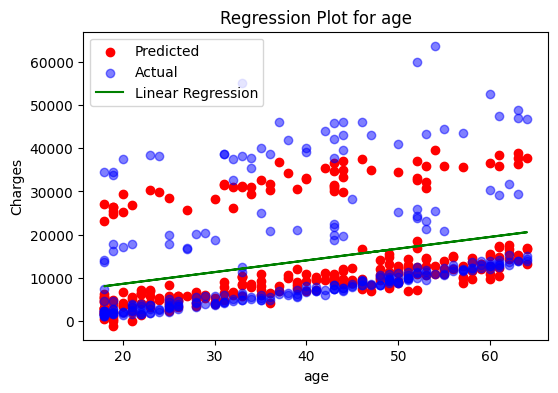

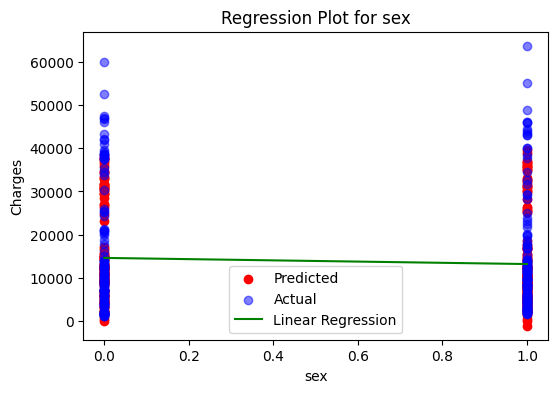

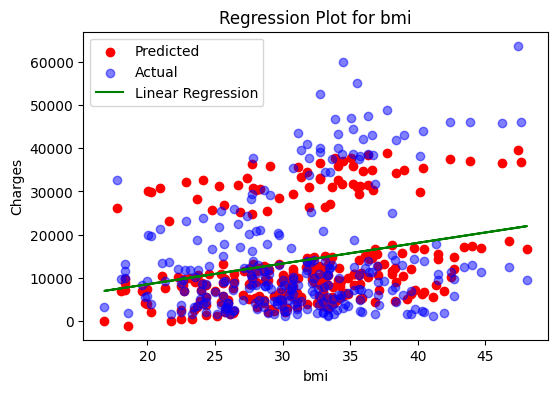

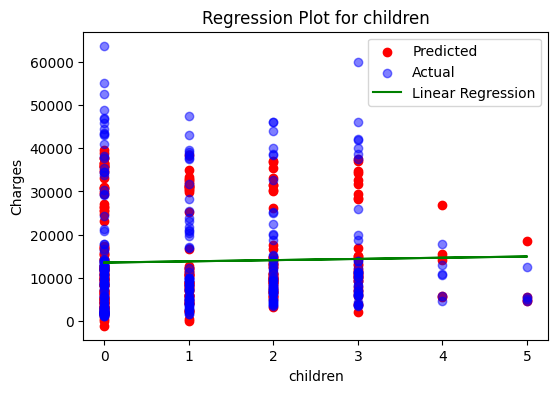

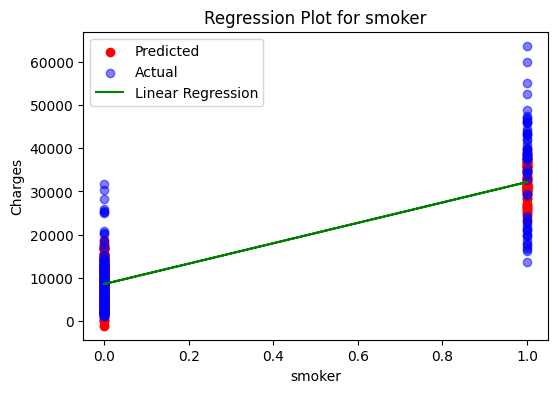

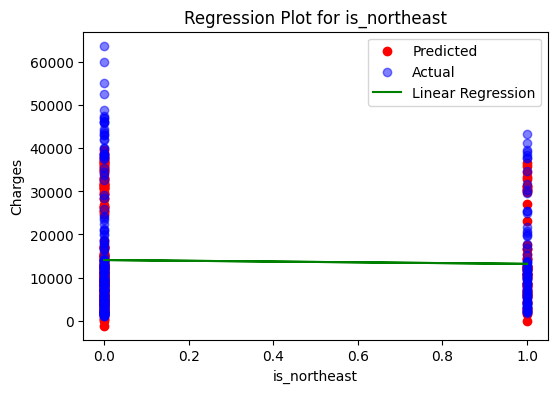

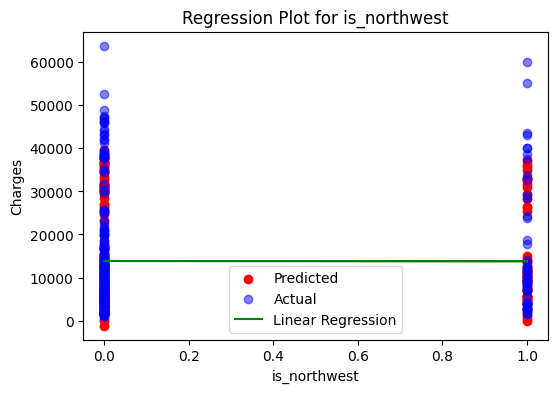

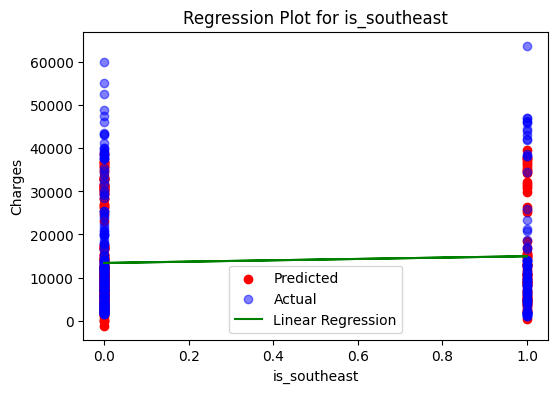

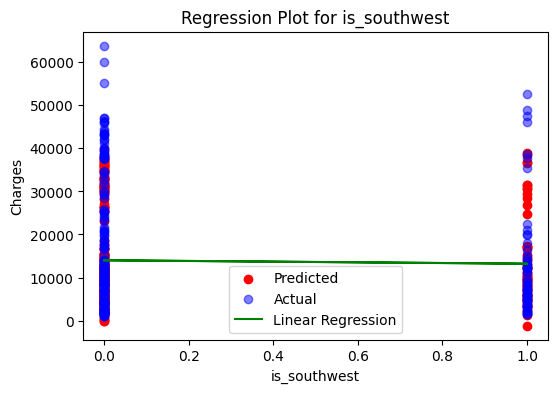

In [29]:
from sklearn.linear_model import LinearRegression

# Créer une régression linéaire
regression = LinearRegression()

# Parcourir chaque colonne de X_test
for col in X_test.columns:
    # Créer une figure et un axe pour chaque colonne
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Fit de la régression linéaire sur la colonne actuelle et les valeurs prédites
    regression.fit(X_test[[col]], y_pred)
    
    # Tracer les valeurs prédites en fonction de la colonne actuelle
    ax.scatter(X_test[col], y_pred, color='red', label='Predicted')
    
    # Tracer les valeurs réelles en fonction de la colonne actuelle
    ax.scatter(X_test[col], y_test, color='blue', alpha=0.5, label='Actual')
    
    # Tracer la ligne de régression linéaire pour la colonne actuelle
    ax.plot(X_test[col], regression.predict(X_test[[col]]), color='green', label='Linear Regression')
    
    # Ajouter des étiquettes et une légende pour la colonne actuelle
    ax.set_xlabel(col)
    ax.set_ylabel('Charges')
    ax.legend()
    
    # Afficher le titre basé sur la colonne
    ax.set_title(f'Regression Plot for {col}')
    
    # Afficher le graphique pour la colonne actuelle
    plt.show()
